# Decisions Trees - Feature Importance

This notebook demonstrates evaluating the relative importance of difference features that we might use as input to our machine learning models. We will use the scikit-learn `permutation_feature_importance` algorithm to determine which are the most important input features.

This algorithm works by adding random to noise to inpout features and testing how much performance is degraded by the degradation of input data. This is done for each input variable in turn. If a variable is important, when it is degraded by random noise, there will be a significant degradation in classification accuracy. Conversely, if a feature is nopt important to the classification algorithm, then the added noise will not result in much change to the classification accuracy in the resulting trained model. 

https://scikit-learn.org/stable/modules/permutation_importance.html

In [1]:
import os
import sys
import pathlib
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics
import sklearn.inspection

In [4]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [5]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [6]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [7]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

In [8]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [9]:
root_data_dir

'/data/users/shaddad/xbt-data/'

In [10]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']

In [11]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [12]:
experiment_name = 'nb_single_decisionTree_country'
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_name = 'decision_tree'
suffix='countryAndLatLon'

In [13]:
classifier_opts = {'max_depth': 20,
                   'min_samples_leaf': 1,
                   'criterion': 'gini'
                  }

In [14]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [15]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/users/shaddad/xbt-data/experiment_outputs/nb_single_decisionTree_country


In [16]:
output_fname_template = 'xbt_output_{exp_name}_{subset}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [17]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 52.6 s, sys: 14.3 s, total: 1min 6s
Wall time: 1min 16s


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [18]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 206 ms, sys: 20.4 ms, total: 226 ms
Wall time: 224 ms


In [19]:
xbt_unlabelled = xbt_full_dataset.filter_obs({'labelled': 'unlabelled'})

In [20]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [21]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [22]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)

CPU times: user 21.4 ms, sys: 1.1 ms, total: 22.5 ms
Wall time: 21.1 ms


In [23]:
%%time
xbt_unseen = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_working = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

CPU times: user 9.87 s, sys: 1.56 ms, total: 9.87 s
Wall time: 9.87 s


In [24]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [25]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [26]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=['instrument', 'year'])

CPU times: user 2min 1s, sys: 22.8 s, total: 2min 23s
Wall time: 2min 23s


In [27]:
X_train_all, _, _, _, feature_names = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We are using the scikit-learn classifier as the closest analogue to the structure of the iMeta algorithm. This tree can have many more nodes and leaves than iMeta though. it is quick to train and evaluate so it is a useful starting point for setting up the ML processing pipelines, as all the scikit-learn classifiers have a common interface. 

For the model and manufacturer, we train a Decision ree Classifier, then use it to predict values for the train and test sets. We then calculate the accuracy metrics for each for the whole dataset. 

I am using precision, recall and F1 as fairly standard ML metrics of accuracy. Recall is what has been used in the two previous papers (Palmer et. al, Leahy and Llopis et al) so that is the focus. Support is a useful to see what proportion of the profiles in the dataset belong to each of the different classes.

In [28]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [29]:
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

DecisionTreeClassifier(max_depth=20)

In [30]:
%%time
importances_dict = sklearn.inspection.permutation_importance(
    clf_dt_instr1,
    X_test_all,
    y_instr_test_all,
    n_repeats=10,
    random_state=0,
)    

CPU times: user 48.5 s, sys: 30 s, total: 1min 18s
Wall time: 1min 18s


In [31]:
importance_df = pandas.DataFrame({
    'features': feature_names,
    'importances_mean': importances_dict['importances_mean'],
})

<AxesSubplot:title={'center':'XBT Feature importance'}, xlabel='features'>

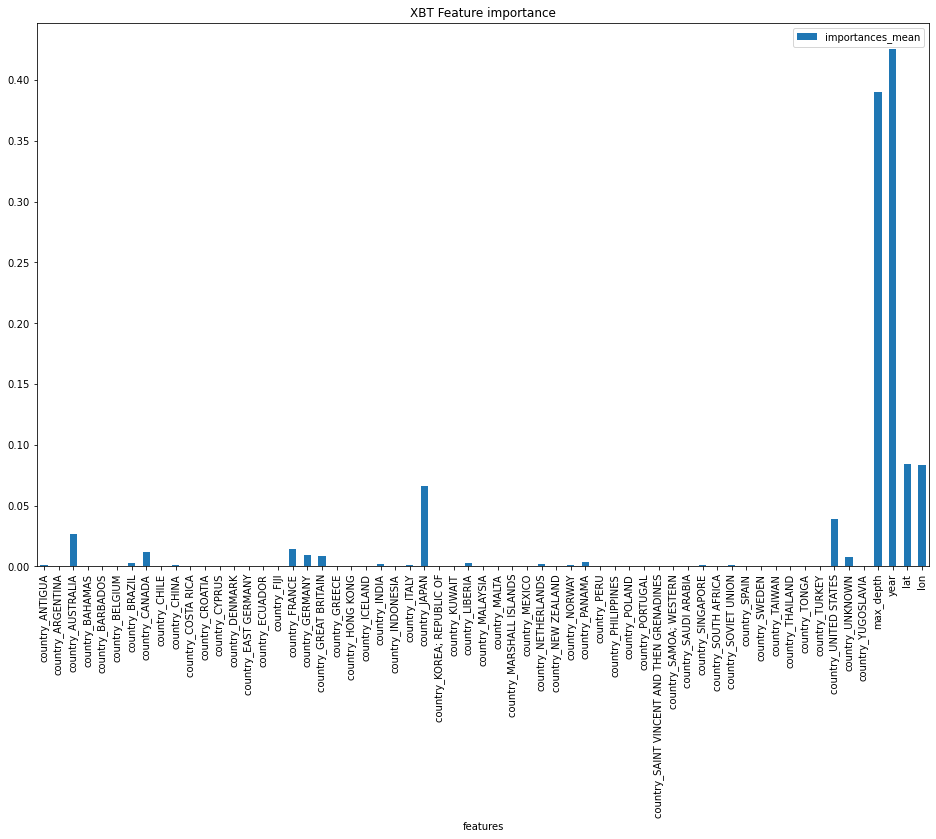

In [32]:
fig1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = fig1.add_subplot(1,1,1, title='XBT Feature importance')
importance_df.plot.bar(x='features', y='importances_mean', ax=ax1)

We see that maximum depth (derived from the depth profile information) and year of measurement are the most important. We see that the country codes for certain countries are the most important, reflecting the countries that have made the most measurements.

## Other classification algorithms

Lets compare results for other classification algorithms to see how feature importance might differ based on the type of algorithm.

In [33]:
batch_importances_root_dir = '/scratch/shaddad/xbt-data/journal_paper_importance_202104/'
batch_importances_file_list = {
    'random_forest': 'RandomForest_countryLatLon/xbt_importance_RandomForest_countryLatLon_20210422_1756.csv',
    'decision_tree': 'decisionTree_countryLatLon/xbt_importance_decisionTree_countryLatLon_20210422_1756.csv',
    'logistic_regression': 'logreg_country/xbt_importance_logreg_country_20210422_1756.csv',
    'neural_network': 'mlp_countryLatLon/xbt_importance_mlp_countryLatLon_20210422_1756.csv',
}

In [34]:
batch_importances_path_list = {clf_name: os.path.join(batch_importances_root_dir,
                                            fn1
                                           ) for clf_name, fn1 in batch_importances_file_list.items()}

In [35]:
importances_df_list = {clf_name: pandas.read_csv(p1) for clf_name, p1 in batch_importances_path_list.items()}

In [36]:
importances_df_list = {clf_name: df1.rename({
    'importances_stdev': f'importances_std_{clf_name}',
    'importances_mean': f'importances_mean_{clf_name}',
},axis='columns') for clf_name, df1 in importances_df_list.items()}

In [37]:
batch_importances_df = functools.reduce(lambda x,y: pandas.merge(x,y, on='instrument'), importances_df_list.values()) 

In [38]:
batch_importances_df

,Unnamed: 0_x,instrument,importances_mean_random_forest,importances_std_random_forest,Unnamed: 0_y,importances_mean_decision_tree,importances_std_decision_tree,Unnamed: 0_x,importances_mean_logistic_regression,importances_std_logistic_regression,Unnamed: 0_y,importances_mean_neural_network,importances_std_neural_network
0,0,country_ANTIGUA,0.000784,0.000014,0,0.000411,0.000010,0,0.000375,0.000053,0,0.004248,0.000064
1,1,country_ARGENTINA,0.000098,0.000000,1,0.000011,0.000000,1,0.000005,0.000012,1,0.000335,0.000031
2,2,country_AUSTRALIA,0.016746,0.000143,2,0.015524,0.000144,2,0.036781,0.000324,2,0.068405,0.000364
3,3,country_BAHAMAS,0.000354,0.000021,3,0.000307,0.000029,3,0.003101,0.000127,3,0.002674,0.000096
4,4,country_BARBADOS,0.000186,0.000017,4,0.000293,0.000032,4,0.001657,0.000043,4,0.003060,0.000064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,56,country_YUGOSLAVIA,0.000146,0.000002,56,0.000081,0.000002,56,-0.000006,0.000009,56,0.000545,0.000033
57,57,lat,0.063149,0.000355,57,0.082433,0.000445,59,0.018446,0.000415,59,0.032689,0.000314
58,58,lon,0.064826,0.000404,58,0.096022,0.000434,60,0.001162,0.000241,60,0.009857,0.000297
59,59,max_depth,0.315568,0.000901,59,0.402017,0.001250,57,0.166304,0.000804,57,0.317479,0.000641


<AxesSubplot:title={'center':'comparison of feature importances for algorithms'}, xlabel='instrument'>

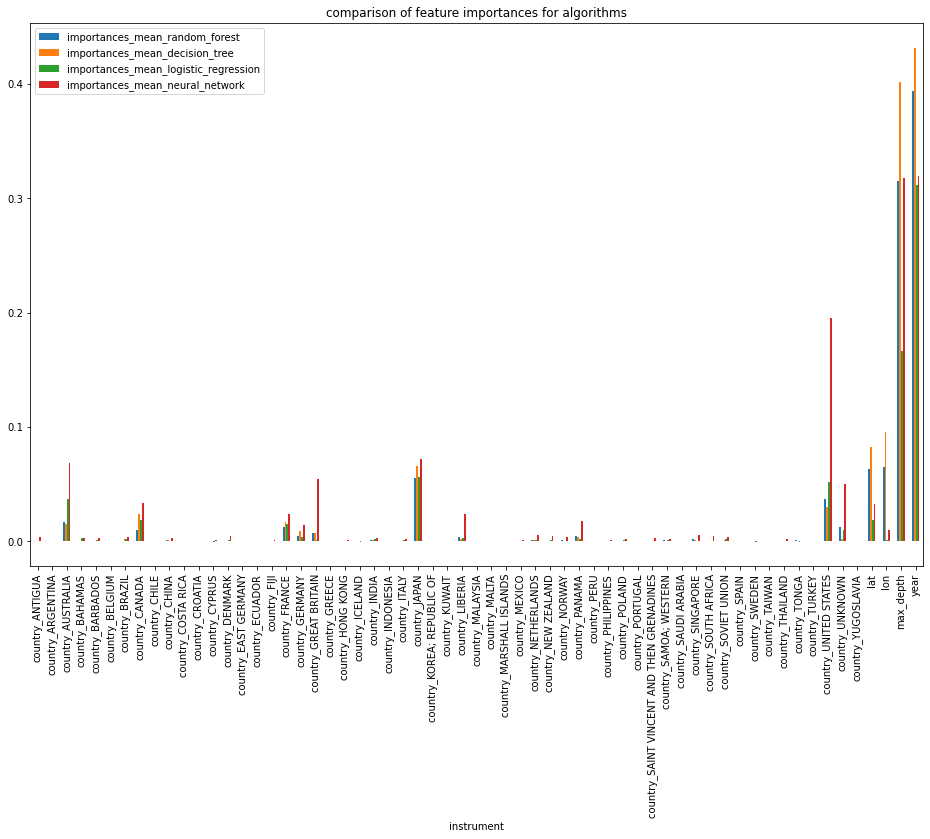

In [39]:
fig_batch_importances = matplotlib.pyplot.figure('batch_importances', figsize=(16,10))
ax_batch_importances = fig_batch_importances.add_subplot(1,1,1, title='comparison of feature importances for algorithms')
batch_importances_df.plot.bar(x='instrument', 
                              y=[f'importances_mean_{clf_name}' for clf_name in importances_df_list.keys()],
                             ax=ax_batch_importances)